# Importing of packages

In [52]:
#packages
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Functions

### Sketching function

In [56]:
def sketch_matrix(m, n_columns, non_zero_entries):
    #matrix with all zero entries
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    
    #loop through each columns to edit the non zero entries in
    for col in range(n_columns):
        # Randomly select position of non_zero entries
        nz_positions = np.random.choice(m, non_zero_entries, replace=False)
        
        # Randomly assign values of either 1 or -1 to these positions
        values = np.random.choice([1, -1], non_zero_entries)* scaling_factor
        
        # Assign the values to the selected positions in the column
        for idx, value in zip(nz_positions, values):
            S[idx, col] = value
    
    return S

### Compute min max svd to be used for analysis

In [57]:
def compute_min_max_svd(matrix):
    # SVD computation only keep the singular values
    _, s, _ = np.linalg.svd(matrix, full_matrices=False)
    return np.min(s), np.max(s)

### Sketched least squares

In [232]:
#Higher leverage scores indicate more influential data points.
def estimate_leverage_scores(A, R, gamma):
    """Estimate leverage scores ˜li for each row using matrix R (similar to Lemma 5.1)."""
    n, d = A.shape
    k = int(np.ceil(d / gamma))  # Choose k based on γ
    G = np.random.randn(d, k) / np.sqrt(k) #scale the matrix
    ARG = A @ (R @ G)
    leverage_scores = np.sum(ARG ** 2, axis=1)
    
    return leverage_scores

def fast_least_squares_sgd(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Parameters:
    - A: Data
    - b: label
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape
    
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd, max_svd = compute_min_max_svd(SA)

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x , min_svd , max_svd

## Sketched least square accounting for intercept

In [233]:
def fast_least_squares_sgd_with_intercept(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Parameters:
    - A: Data
    - b: label
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept
    
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd, max_svd = compute_min_max_svd(SA)

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x[1:],x[0], min_svd , max_svd

## Regularized sketching function accounting for intercept

In [234]:
def compute_effective_dimension(A, lambda_reg):
    """Computes the lambda-effective dimension d_lambda."""
    d = A.shape[1]
    I = np.eye(d)
    return np.trace(A.T @ A @ np.linalg.inv(A.T @ A + lambda_reg * I))

def fast_least_squares_sgd_regularized_with_intercept(A, b, non_zero_entries, m, lambda_reg, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Implements fast least squares using mini-batch SGD with scaled regularization.

    Parameters:
    - A: (n, d) NumPy array (design matrix).
    - b: (n,) NumPy array (target vector).
    - lambda_reg: Regularization parameter λ.
    - m: Sketching matrix size.
    
    Returns:
    - x: (d,) NumPy array (estimated solution).
    """
   
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept 
    d += 1

    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    S = sketch_matrix(m, n, non_zero_entries)
    
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd, max_svd = compute_min_max_svd(SA)

    # Step 4: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 6: Solve for initial x0 using regularized least squares
    I_d = np.eye(d)
    x = np.linalg.solve(SA.T @ SA + lambda_scaled * I_d, SA.T @ Sb)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x[1:],x[0] , lambda_scaled, min_svd , max_svd

# Comparing sketch and non sketch method on synthetic dataset

## Initialise synthetic data

In [61]:
#Feature matrix
n = 10000
d = 100
X = np.random.randn(n, d) #dimension 10000 x 100 (n x d)

#True coefficients
true_x_coefficient = np.random.randn(d)

#target vector
y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

### Regular OLS

In [62]:
ols_model = LinearRegression().fit(X,y)
ols_coeff = ols_model.coef_
y_pred_ols = X @ ols_coeff

### Sketched OLS

In [63]:
non_zero_entries = 10 # < m
m = 2000 # m << n 
sketched_ols_coeff, _, _ = fast_least_squares_sgd(X, y, non_zero_entries, m)
y_pred_sketched_ols = X @ sketched_ols_coeff

## Comparing distance between coefficients between sketched and non sketched

### non sketched

In [68]:
l2_norm = np.linalg.norm(true_x_coefficient - ols_coeff)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(true_x_coefficient)
print(f"Relative distance is {relative_distance}")

Distance is 0.010279880902844611
Relative distance is 0.001059143445535867


### sketched

In [72]:
l2_norm = np.linalg.norm(true_x_coefficient - sketched_ols_coeff)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(true_x_coefficient)
print(f"Relative distance is {relative_distance}")

Distance is 0.021320926578698343
Relative distance is 0.0021967102393502455


Distance and relative distance both small, suggesting that sketching method is decently accurate

## Comparing MSE of sketched vs non sketched

In [73]:
mse_ols = np.mean((y - y_pred_ols)**2)
print(f"MSE of non sketch ols is {mse_ols}")

mse_sketched_ols = np.mean((y - y_pred_sketched_ols)**2)
print(f"MSE of sketched ols is {mse_sketched_ols}")

MSE of non sketch ols is 0.00989142357218728
MSE of sketched ols is 0.010305882909319044


Similar mse suggests that sketching method is almost as accurate as non sketching method

# Effects of sparsity and row(m) of sketching matrix

## Initialise dataset

In [146]:
#Feature matrix
n = 10000
d = 100
X = np.random.randn(n, d) #dimension 10000 x 100 (n x d)

#True coefficients
true_x_coefficient = np.random.randn(d)

#target vector
y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

## m against mse and sketching error

### Initialise parameters

In [147]:
# Define parameters
m_values = list(range(100,n + 1, 100))  # Different sketch sizes, varying m
non_zero_entries = 10

In [100]:
results = []
for m in m_values:
    # Compute estimated x
    x_estimated ,min_svd, max_svd  = fast_least_squares_sgd(X, y, non_zero_entries,m)
    mse = np.mean((X @ x_estimated - y) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD": min_svd,"Max_SVD": max_svd})

# Combine all results
df_results = pd.DataFrame(results)

In [103]:
df_results

,m,MSE,Sparsity,Min_SVD,Max_SVD
0,100,0.052794,10,0.631032,198.021697
1,200,0.019648,10,31.354196,168.970142
2,300,0.015694,10,42.517955,157.439719
3,400,0.012676,10,51.944940,149.300259
4,500,0.012337,10,54.961578,145.009851
...,...,...,...,...,...
95,9600,0.010017,10,86.266181,114.155896
96,9700,0.010024,10,85.960991,113.907231
97,9800,0.010009,10,85.971407,113.746482
98,9900,0.010003,10,86.229375,113.788283


### Convert to csv file

In [107]:
df_results.to_csv('varying_m_dataframe_application.csv', index=False)

In [106]:
#Original svd of data matrix
min_svd_A, max_svd_A = compute_min_max_svd(X)
print(f"min svd of A is {min_svd_A}")
print(f"max svd of A is {max_svd_A}")

min svd of A is 90.61195127377192
max svd of A is 109.84383377981236


### Calculate min/max svd error and sketching_error/inverse sqaure sketching error

In [111]:
df_results["min_svd_error"] = abs(1- (df_results["Min_SVD"]/min_svd_A))
df_results["max_svd_error"] = abs(1- (df_results["Max_SVD"]/max_svd_A))
df_results['sketching_error'] = df_results[["min_svd_error", "max_svd_error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)
df_results

,m,MSE,Sparsity,Min_SVD,Max_SVD,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,100,0.052794,10,0.631032,198.021697,0.993036,0.802757,0.993036,1.014075
1,200,0.019648,10,31.354196,168.970142,0.653973,0.538276,0.653973,2.338194
2,300,0.015694,10,42.517955,157.439719,0.530769,0.433305,0.530769,3.549680
3,400,0.012676,10,51.944940,149.300259,0.426732,0.359205,0.426732,5.491484
4,500,0.012337,10,54.961578,145.009851,0.393440,0.320146,0.393440,6.460153
...,...,...,...,...,...,...,...,...,...
95,9600,0.010017,10,86.266181,114.155896,0.047960,0.039256,0.047960,434.747758
96,9700,0.010024,10,85.960991,113.907231,0.051328,0.036992,0.051328,379.564558
97,9800,0.010009,10,85.971407,113.746482,0.051213,0.035529,0.051213,381.270443
98,9900,0.010003,10,86.229375,113.788283,0.048366,0.035910,0.048366,427.476218


### Visualiation

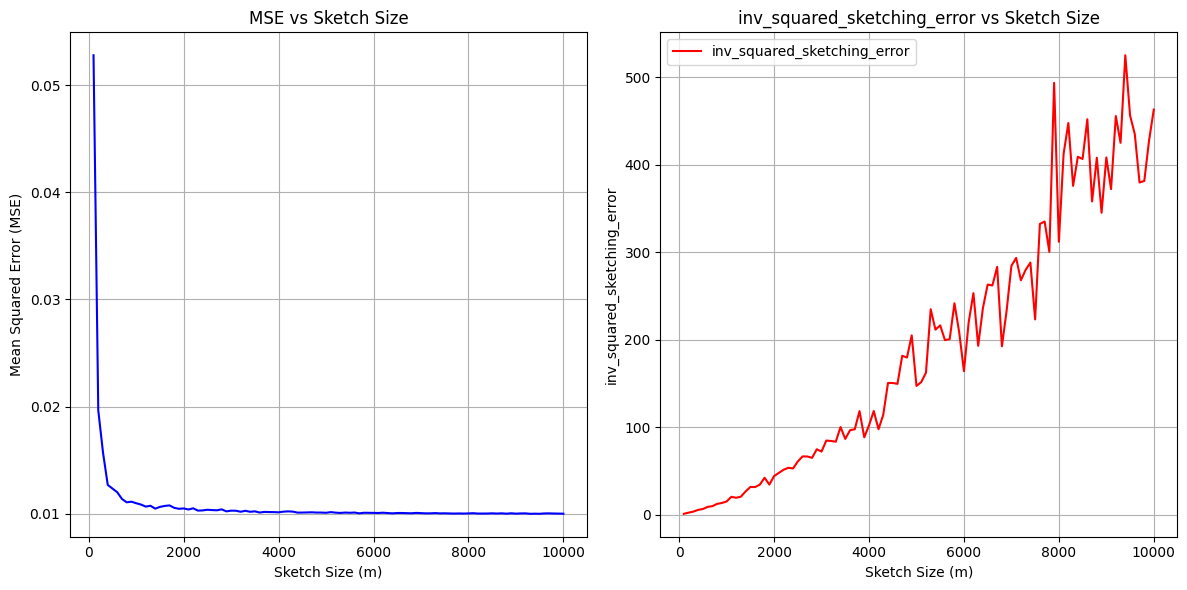

In [112]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results["m"], df_results["MSE"], label="MSE", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sketch Size")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_results["m"], df_results["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sketch Size (m)")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sketch Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

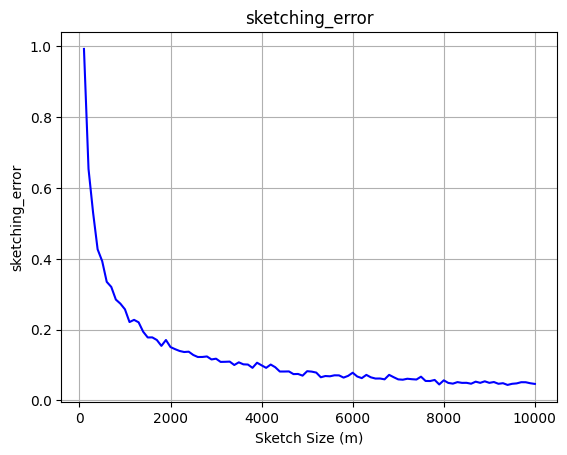

In [113]:
plt.plot(df_results["m"], df_results["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

## s against mse and sketching

In [114]:
#varying s, elbow
m = 2000
non_zero_entries_list = list(range(2,m + 1 ,2))
# Store results
results = []

for non_zero_entries in non_zero_entries_list:
    # Compute estimated x
    x_estimated, min_SVD, max_SVD  = fast_least_squares_sgd(X, y, non_zero_entries,m)
    mse = np.mean((X @ x_estimated - y) ** 2)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD": min_SVD,"Max_SVD": max_SVD})

# Combine all results
df_results = pd.DataFrame(results)

### Convert to csv

In [115]:
df_results.to_csv('varying_s_data_application.csv', index=False)

In [116]:
df_results

,m,MSE,Sparsity,Min_SVD,Max_SVD
0,2000,0.010330,2,76.967510,123.322282
1,2000,0.010487,4,75.143689,124.451920
2,2000,0.010289,6,77.098177,124.644953
3,2000,0.010400,8,76.558350,125.820104
4,2000,0.010414,10,77.192759,123.528333
...,...,...,...,...,...
995,2000,0.010416,1992,76.845905,124.548521
996,2000,0.010286,1994,76.447160,124.362150
997,2000,0.010488,1996,76.527861,124.672703
998,2000,0.010409,1998,74.776283,123.648034


### Calculate min/max svd error and sketching_error/inverse sqaure sketching error

In [117]:
df_results["min_svd_error"] = abs(1- (df_results["Min_SVD"]/min_svd_A))
df_results["max_svd_error"] = abs(1- (df_results["Max_SVD"]/max_svd_A))
df_results['sketching_error'] = df_results[["min_svd_error", "max_svd_error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)
df_results

,m,MSE,Sparsity,Min_SVD,Max_SVD,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,2000,0.010330,2,76.967510,123.322282,0.150581,0.122706,0.150581,44.102117
1,2000,0.010487,4,75.143689,124.451920,0.170709,0.132990,0.170709,34.315308
2,2000,0.010289,6,77.098177,124.644953,0.149139,0.134747,0.149139,44.959106
3,2000,0.010400,8,76.558350,125.820104,0.155097,0.145445,0.155097,41.571499
4,2000,0.010414,10,77.192759,123.528333,0.148095,0.124581,0.148095,45.595103
...,...,...,...,...,...,...,...,...,...
995,2000,0.010416,1992,76.845905,124.548521,0.151923,0.133869,0.151923,43.326390
996,2000,0.010286,1994,76.447160,124.362150,0.156324,0.132172,0.156324,40.921413
997,2000,0.010488,1996,76.527861,124.672703,0.155433,0.135000,0.155433,41.391707
998,2000,0.010409,1998,74.776283,123.648034,0.174764,0.125671,0.174764,32.741472


### Visualiation

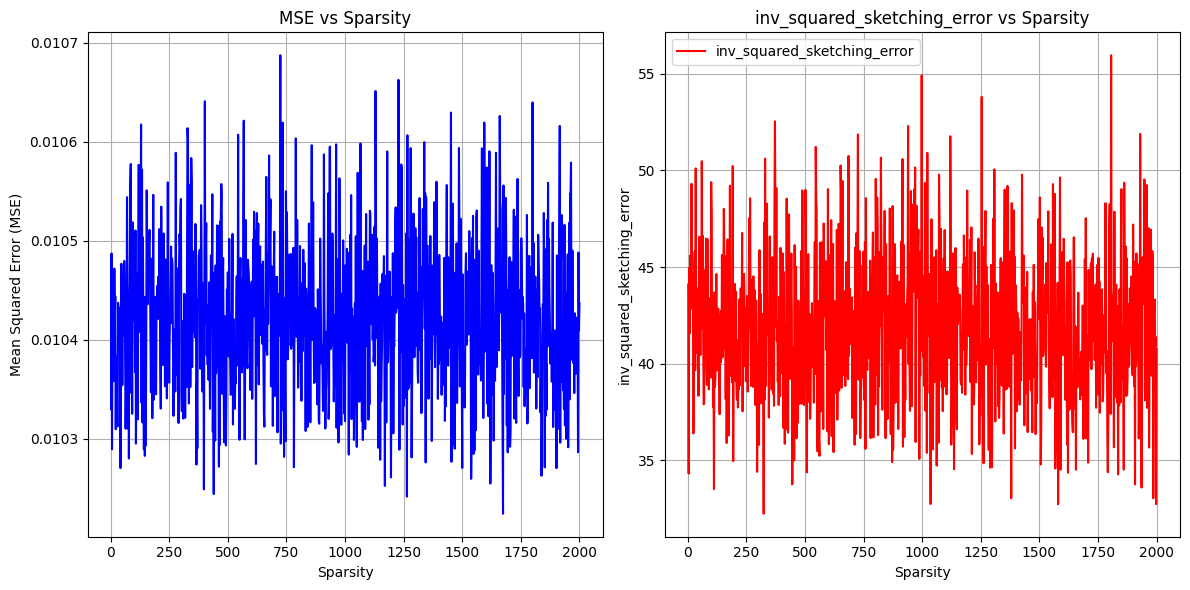

In [119]:
# Plot MSE vs s
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results["Sparsity"], df_results["MSE"], label="MSE", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sparsity")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_results["Sparsity"], df_results["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sparsity")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sparsity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

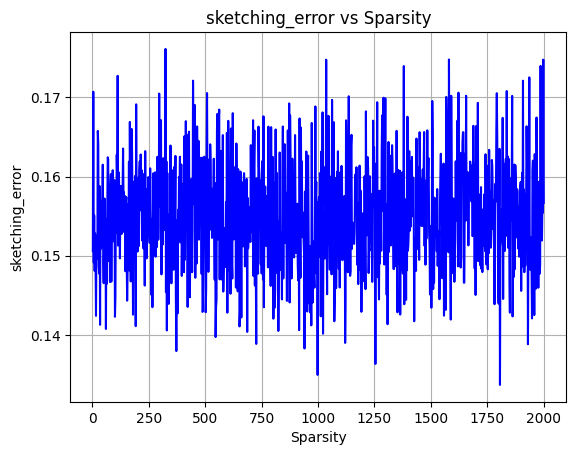

In [121]:
plt.plot(df_results["Sparsity"], df_results["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("sketching_error")
plt.title("sketching_error vs Sparsity")
plt.grid(True)

# Housing dataset

## Data parsing and processing

In [122]:
df = pd.read_csv("../Dataset/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [123]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [124]:
X = df.drop(columns=['price'])
y = df['price']
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_cols)   # OneHotEncode categorical features
    ])

X_transformed = preprocessor.fit_transform(X)

### Train test split

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=42)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Initialising parameters

In [127]:
non_zero_entries = 10 #sparsity
n, d = X_train.shape 
m = 300 # lesser than n 

### OLS Sketched vs default

#### MSE for sketched

In [128]:
x_estimated, min_svd, max_svd = fast_least_squares_sgd(X_train, y_train, non_zero_entries, m)
y_pred_sketch = X_test @ x_estimated
mse_sketch = np.mean((y_pred_sketch - y_test)**2)
mse_sketch

1512835415940.0642

#### MSE for default OLS

In [129]:
x_ols, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
y_pred_ols = X_test @ x_ols
mse_ols = np.mean((y_pred_ols - y_test)**2)
mse_ols

1506230725917.457

#### Analysis/comparison

In [130]:
relative_difference = abs(mse_sketch - mse_ols) / mse_ols
print(relative_difference)
mse_ratio = mse_sketch / mse_ols
print(mse_ratio)

0.0043849125561983265
1.0043849125561983


For relative difference : sketch approximation performs similarly to the OLS model with respect to error.
mse_ratio > 1, the sketch has a higher error compared to OLS.

# Student performance dataset

## Data parsing and processing

In [149]:
df = pd.read_csv("../Dataset/Student_Performance.csv")
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [150]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [151]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [152]:
df.shape

(10000, 6)

In [153]:
X = df.drop(columns='Performance Index')
y = df['Performance Index']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Train test split

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train.shape

(8000, 5)

### Intialising parameters

In [155]:
non_zero_entries = 10 #sparsity (<m)
n, d = X_train.shape 
m = 2000 # lesser than n 

### MSE of regular OLS

In [159]:
x_ols, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
y_pred_ols = X_test @ x_ols
mse_ols = np.mean((y_pred_ols - y_test)**2)
mse_ols

3052.59869597723

### MSE of ridge regression

In [157]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
x_ridge = ridge_model.coef_ #coefficient
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge

4.083211367310288

Difference might be due to intercept

### MSE of regular OLS accounting for y-intercept

In [163]:
X_train_with_intercept = np.column_stack([np.ones(X_train.shape[0]), X_train])
X_test_with_intercept = np.column_stack([np.ones(X_test.shape[0]), X_test])
x_ols, _, _, _ = np.linalg.lstsq(X_train_with_intercept, y_train, rcond=None)
y_pred_ols = X_test_with_intercept @ x_ols
mse_ols = np.mean((y_pred_ols - y_test)**2)
mse_ols

4.082628398521851

### Sketched OLS with intercept

In [168]:
x_sketched, intercept ,min_svd_error, max_svd_error = fast_least_squares_sgd_with_intercept(X_train, y_train, non_zero_entries, m)
y_pred_sketch = X_test @ x_sketched + intercept
mse_sgd_sketch = mean_squared_error(y_test, y_pred_sketch)
mse_sgd_sketch

4.103913260705038

### Sketched OLS regularised with intercept

In [185]:
x_sketched_regularised, intercept, _ ,min_svd_error, max_svd_error = fast_least_squares_sgd_regularized_with_intercept(X_train, y_train, non_zero_entries, m,lambda_reg=1e-3)
y_pred_sketch = X_test @ x_sketched_regularised + intercept
mse_sgd_sketch_regularised = mean_squared_error(y_test, y_pred_sketch)
mse_sgd_sketch_regularised

4.089354033000808

# Further analysis

## Sketched non regularisation

In [189]:
non_zero_entries = 10 #sparsity (<m)
n, d = X_train.shape 
m = 2000 # lesser than n 
iterations = 10
min_svds = []
max_svds = []
x_sgd_results = []
mse_list = []
intercept_list = []

# Iterate over the number of iterations
for i in range(iterations):
    x_sgd, intercept, min_svd, max_svd = fast_least_squares_sgd_with_intercept(X_train, y_train, non_zero_entries, m)
    x_sgd_results.append(x_sgd)
    min_svds.append(min_svd)
    max_svds.append(max_svd)
    intercept_list.append(intercept)
    y_pred_sgd = X_test @ x_sgd + intercept
    mse_sgd_reg = mean_squared_error(y_test, y_pred_sgd)
    mse_list.append(mse_sgd_reg)


x_sgd_sketch_results_df = pd.DataFrame(x_sgd_results)
x_sgd_sketch_results_df["intercept"] = intercept_list
x_sgd_sketch_results_df["Min_SVD"] = min_svds
x_sgd_sketch_results_df["Max_SVD"] = max_svds
x_sgd_sketch_results_df["mse"] = mse_list

In [190]:
x_sgd_sketch_results_df

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343
5,7.326196,17.636917,0.281281,0.841707,0.583430,55.140216,85.577476,93.513911,4.080667
6,7.413774,17.553768,0.317450,0.839714,0.627275,55.265694,85.643134,92.373176,4.115988
7,7.399924,17.665336,0.240942,0.874828,0.555778,55.213840,84.640479,93.225581,4.078413
8,7.340988,17.644951,0.303556,0.810459,0.506969,55.239749,86.869305,93.154647,4.087438
9,7.499027,17.625939,0.273125,0.812884,0.506624,55.246272,85.830607,92.347580,4.103677


## Sketched regularisation

In [193]:
intercept_list = []
min_svds = []
max_svds = []
x_sgd_reg_results = []
mse_list = []

# Iterate over the number of iterations
for i in range(iterations):
    x_sgd_reg, reg_intercept, _, min_svd, max_svd = fast_least_squares_sgd_regularized_with_intercept(X_train, y_train, non_zero_entries,m, lambda_reg=1e-3)
    x_sgd_reg_results.append(x_sgd_reg)
    intercept_list.append(reg_intercept)
    min_svds.append(min_svd)
    max_svds.append(max_svd)
    y_pred_sgd_reg = X_test @ x_sgd_reg + reg_intercept
    mse_sgd_reg = mean_squared_error(y_test, y_pred_sgd_reg)
    mse_list.append(mse_sgd_reg)


x_sgd_results_reg_df = pd.DataFrame(x_sgd_reg_results)
x_sgd_results_reg_df["intercept"] = intercept_list
x_sgd_results_reg_df["Min_SVD"] = min_svds
x_sgd_results_reg_df["Max_SVD"] = max_svds
x_sgd_results_reg_df["mse"] = mse_list

In [194]:
x_sgd_results_reg_df

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038
5,7.324919,17.657071,0.307228,0.790117,0.577996,55.252545,85.651464,94.186057,4.084665
6,7.393180,17.569311,0.331994,0.813311,0.465992,55.261643,84.169013,92.861517,4.119649
7,7.406991,17.587046,0.232537,0.816973,0.587530,55.212058,87.271688,94.017591,4.099665
8,7.360547,17.624271,0.335073,0.806664,0.533025,55.234786,84.073440,92.885563,4.087523
9,7.354081,17.638121,0.257065,0.793418,0.547408,55.227485,83.258195,93.611477,4.086335


## Put the coeefficient and intercept into an array

### Sketched non reg

In [200]:
x_sgd_sketch_results_df["x_array"] = x_sgd_sketch_results_df.iloc[:, 0:6].apply(lambda row: row.values, axis=1)
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091,"[7.463638335810351, 17.625802624227365, 0.2248..."
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019,"[7.41573359230728, 17.664147966347528, 0.28691..."
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479,"[7.398503570854378, 17.626566643451415, 0.2811..."
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110,"[7.387844073722896, 17.66211961569598, 0.31476..."
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343,"[7.370297808466278, 17.655840697216995, 0.2906..."


### Sketched reg

In [203]:
x_sgd_results_reg_df["x_array"] = x_sgd_results_reg_df.iloc[:, 0:6].apply(lambda row: row.values, axis=1)
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188,"[7.323648490313978, 17.6591899750168, 0.343482..."
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066,"[7.340991879591277, 17.613063220199084, 0.2142..."
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786,"[7.3676779013826295, 17.632038694086436, 0.300..."
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244,"[7.337394141179786, 17.693364878125802, 0.3235..."
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038,"[7.394111177416938, 17.614093863930886, 0.2606..."


## Comparing distance of coefficient

### Default OLS vs sketched OLS

#### Reorder intercept to last index 

In [206]:
ols_coef = np.append(x_ols[1:],x_ols[0])
ols_coef

array([ 7.38559242, 17.63689926,  0.30429188,  0.80878696,  0.55001995,
       55.2407568 ])

In [210]:
distances = []
for index, row in x_sgd_sketch_results_df.iterrows():
    # Extract x_sgd_array from each row
    x_sgd_array = row['x_array']
    # Calculate the distance from regression_coeff
    distance = np.linalg.norm(x_sgd_array - ols_coef)
    # Append the calculated distance
    distances.append(distance)

# Assign the calculated distances to the new 'distance' column
x_sgd_sketch_results_df['distance'] = distances
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091,"[7.463638335810351, 17.625802624227365, 0.2248...",0.130072
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019,"[7.41573359230728, 17.664147966347528, 0.28691...",0.084751
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479,"[7.398503570854378, 17.626566643451415, 0.2811...",0.092329
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110,"[7.387844073722896, 17.66211961569598, 0.31476...",0.042082
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343,"[7.370297808466278, 17.655840697216995, 0.2906...",0.054451


### Ridge vs sketch regularisation

#### merge coefficient with intercept for ridge

In [212]:
ridge_coef = np.append(x_ridge,ridge_model.intercept_)
ridge_coef

array([ 7.38465051, 17.63468517,  0.30426091,  0.80869184,  0.54998809,
       55.24076516])

In [213]:
distances = []
for index, row in x_sgd_results_reg_df.iterrows():
    # Extract x_sgd_array from each row
    x_sgd_array = row['x_array']
    # Calculate the distance from regression_coeff
    distance = np.linalg.norm(x_sgd_array - ridge_coef)
    # Append the calculated distance
    distances.append(distance)

# Assign the calculated distances to the new 'distance' column
x_sgd_results_reg_df['distance'] = distances
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188,"[7.323648490313978, 17.6591899750168, 0.343482...",0.090485
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066,"[7.340991879591277, 17.613063220199084, 0.2142...",0.112713
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786,"[7.3676779013826295, 17.632038694086436, 0.300...",0.070355
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244,"[7.337394141179786, 17.693364878125802, 0.3235...",0.095371
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038,"[7.394111177416938, 17.614093863930886, 0.2606...",0.056199


## Sketching error

### SVD of original train data

In [215]:
min_svd_X_train, max_svd_X_train = compute_min_max_svd(X_train)
print(f"min svd of A is {min_svd_X_train}")
print(f"max svd of A is {max_svd_X_train}")

min svd of A is 88.20594154424597
max svd of A is 90.49370701837194


### Sketching error and inverse sketching error squared of non regularisation sketch

In [217]:
x_sgd_sketch_results_df["min_svd_error"] = abs(1- (x_sgd_sketch_results_df["Min_SVD"]/min_svd_X_train))
x_sgd_sketch_results_df["max_svd_error"] = abs(1- (x_sgd_sketch_results_df["Max_SVD"]/max_svd_X_train))
x_sgd_sketch_results_df['sketching_error'] = x_sgd_sketch_results_df[["min_svd_error", "max_svd_error"]].max(axis=1)
x_sgd_sketch_results_df["inv_squared_sketching_error"] = 1 / (x_sgd_sketch_results_df["sketching_error"] ** 2)
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091,"[7.463638335810351, 17.625802624227365, 0.2248...",0.130072,0.038269,0.031732,0.038269,682.812814
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019,"[7.41573359230728, 17.664147966347528, 0.28691...",0.084751,0.041147,0.019589,0.041147,590.654089
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479,"[7.398503570854378, 17.626566643451415, 0.2811...",0.092329,0.029050,0.034343,0.034343,847.835166
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110,"[7.387844073722896, 17.66211961569598, 0.31476...",0.042082,0.008585,0.025535,0.025535,1533.714629
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343,"[7.370297808466278, 17.655840697216995, 0.2906...",0.054451,0.038235,0.032835,0.038235,684.039746


### Sketching error and inverse sketching error squared of regularisation sketch

In [218]:
x_sgd_results_reg_df["min_svd_error"] = abs(1- (x_sgd_results_reg_df["Min_SVD"]/min_svd_X_train))
x_sgd_results_reg_df["max_svd_error"] = abs(1- (x_sgd_results_reg_df["Max_SVD"]/max_svd_X_train))
x_sgd_results_reg_df['sketching_error'] = x_sgd_results_reg_df[["min_svd_error", "max_svd_error"]].max(axis=1)
x_sgd_results_reg_df["inv_squared_sketching_error"] = 1 / (x_sgd_results_reg_df["sketching_error"] ** 2)
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188,"[7.323648490313978, 17.6591899750168, 0.343482...",0.090485,0.025288,0.015325,0.025288,1563.780618
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066,"[7.340991879591277, 17.613063220199084, 0.2142...",0.112713,0.035249,0.037195,0.037195,722.838851
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786,"[7.3676779013826295, 17.632038694086436, 0.300...",0.070355,0.040969,0.033703,0.040969,595.796061
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244,"[7.337394141179786, 17.693364878125802, 0.3235...",0.095371,0.036115,0.021856,0.036115,766.683127
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038,"[7.394111177416938, 17.614093863930886, 0.2606...",0.056199,0.028468,0.029299,0.029299,1164.935530


#### Average performance

##### non regularisation sketch

In [220]:
temp = x_sgd_sketch_results_df.drop(columns = "x_array")
sketch_average = temp.mean()
sketch_average

0                                7.401593
1                               17.636139
2                                0.281466
3                                0.822215
4                                0.563802
intercept                       55.245430
Min_SVD                         85.589362
Max_SVD                         93.011757
mse                              4.092222
distance                         0.094514
min_svd_error                    0.029664
max_svd_error                    0.027826
sketching_error                  0.033671
inv_squared_sketching_error    956.891803
dtype: float64

##### regularisation sketch

In [221]:
temp = x_sgd_results_reg_df.drop(columns = "x_array")
sketch_average = temp.mean()
sketch_average

0                                7.360354
1                               17.628757
2                                0.290641
3                                0.813864
4                                0.548638
intercept                       55.240306
Min_SVD                         85.080355
Max_SVD                         93.246249
mse                              4.092216
distance                         0.081595
min_svd_error                    0.035435
max_svd_error                    0.030417
sketching_error                  0.039732
inv_squared_sketching_error    732.498225
dtype: float64

# Comparing computational cost in term of time

## Edit function as no longer require svd computation

### non regularisation with sketch and intercept

In [256]:
def fast_least_squares_sgd_with_intercept_nosvd(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept
    
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 3: Compute QR decomposition of SA
    _, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x[1:],x[0]

### Regularisation sketch with intercept

In [230]:
def fast_least_squares_sgd_regularized_with_intercept_nosvd(A, b, non_zero_entries, m, lambda_reg, T=100, eta=0.01, gamma=0.1, batch_size=10):
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept 
    d += 1

    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    S = sketch_matrix(m, n, non_zero_entries)
    
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    # Step 4: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 6: Solve for initial x0 using regularized least squares
    I_d = np.eye(d)
    x = np.linalg.solve(SA.T @ SA + lambda_scaled * I_d, SA.T @ Sb)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x[1:],x[0] , lambda_scaled

## Time comparison

In [253]:
m = 500
print(m) 
non_zero_entries = 3
print(non_zero_entries)

500
3


### regular OLS non sketched

In [248]:
iterations = 1000
results = []

for i in range(iterations):
    start_time = time.time()
    x_ols, _, _, _ = np.linalg.lstsq(X_train_with_intercept, y_train, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    
    results.append({'iteration': i, 'time': iteration_time})

# Create a new DataFrame with the results
time_OLS_df = pd.DataFrame(results)

In [249]:
time_OLS_df.head()

,iteration,time
0,0,0.000996
1,1,0.000000
2,2,0.001001
3,3,0.000000
4,4,0.001000


In [250]:
OLS_total_time = time_OLS_df['time'].sum()
OLS_total_time

0.3450648784637451

### OLS sketched

In [257]:
iterations = 1
results = []

for i in range(iterations):
    start_time = time.time()
    x_ols, _ = fast_least_squares_sgd_with_intercept_nosvd(X_train, y_train, non_zero_entries, m)
    end_time = time.time()
    iteration_time = end_time - start_time
    
    results.append({'iteration': i, 'time': iteration_time})

# Create a new DataFrame with the results
time_OLS_sketch_df = pd.DataFrame(results)

In [258]:
time_OLS_sketch_df.head()

,iteration,time
0,0,0.335566
